In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb

In [3]:
original_df = pd.read_csv('./train.csv')
main_test_df = pd.read_csv('./test.csv')

In [4]:
no_outlier_df = original_df[original_df['Height'] <= 0.3]
no_outlier_df = no_outlier_df[no_outlier_df['Whole weight'] <= 2.25]
no_outlier_df = no_outlier_df[no_outlier_df['Whole weight.1'] <= 1]
no_outlier_df = no_outlier_df[no_outlier_df['Whole weight.2'] <= 0.5]
no_outlier_df = no_outlier_df[no_outlier_df['Shell weight'] <= 0.6]

In [5]:
def generate_features(df):
    df['Min Whole Weight'] = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].min(axis=1)
    df['Max Whole Weight'] = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].max(axis=1)
    df['CV Length'] = df['Length'] / df['Length'].mean()

    df['Aspect Ratio'] = df['Length'] / df['Diameter']
    df['Shell Weight Ratio'] = df['Shell weight'] / df['Whole weight']
    df['Density'] = df['Whole weight'] / (df['Length'] * df['Diameter'] * df['Height'])  # Assuming cylinder
    df['Density'] = np.where(df['Density'] == np.inf, 0, df['Density'])
    df['Volume'] = np.pi * (df['Diameter'] / 2) ** 2 * df['Height']  # Assuming cylinder
    df['Length to Height Ratio'] = df['Length'] / df['Height']
    df['Length to Height Ratio'] = np.where(df['Length to Height Ratio'] == np.inf, 0, df['Length to Height Ratio'])

    df['Weight Diff Max-Min'] = df['Max Whole Weight'] - df['Min Whole Weight']
    df['Avg Whole Weight'] = (df['Whole weight'] + df['Whole weight.1'] + df['Whole weight.2']) / 3
    weight_std = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].std(axis=1)
    df['Std Weight Measures'] = weight_std
    df['CV Whole Weight'] = np.where(weight_std == 0, 0, weight_std / df['Avg Whole Weight'])

    df['Is Male'] = df['Sex'].apply(lambda x: 1 if x == "M" else 0)
    df['Is Female'] = df['Sex'].apply(lambda x: 1 if x == "F" else 0)
    df['Is Infant'] = df['Sex'].apply(lambda x: 1 if x == "I" else 0)
    

    df['Length x Diameter'] = df['Length'] * df['Diameter']
    df['Length x Height'] = df['Length'] * df['Height']
    df['Diameter x Height'] = df['Diameter'] * df['Height']
    df['Length x Shell Weight'] = df['Length'] * df['Shell weight']

    return df

In [6]:
df = generate_features(no_outlier_df.copy())
test_df = generate_features(main_test_df.copy())

In [7]:
scaler = MinMaxScaler()
numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight',
       'Min Whole Weight', 'Max Whole Weight', 'CV Length', 'Aspect Ratio',
       'Shell Weight Ratio', 'Density', 'Volume', 'Length to Height Ratio',
       'Weight Diff Max-Min', 'Avg Whole Weight', 'Std Weight Measures',
       'CV Whole Weight','Length x Diameter', 'Length x Height', 'Diameter x Height',
       'Length x Shell Weight']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

In [8]:
features = ['Is Male', 'Is Female', 'Is Infant'] + numerical_features
target = ['Rings']

In [9]:
X, y = df[features], df[target]
X_np = X.values
y_np = y.values

In [10]:
def rmsle(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log)))

In [11]:
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 8,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'gamma': 0.4,
    'min_child_weight': 10,
}

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=32)
rmsle_scores = []
feature_importance_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    model = xgb.XGBRegressor(**xgb_params)
        
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmsle = mean_squared_log_error(y_test, y_pred) ** 0.5
    rmsle_scores.append(rmsle)
    
    feature_importance_list.append(model.feature_importances_)

In [12]:
average_rmse = np.mean(rmsle_scores)

print("RMSE:", average_rmse)

RMSE: 0.14960626806536573


In [13]:
rmsle_scores

[0.15049295990612804,
 0.14765243072184467,
 0.14871722509565946,
 0.1508774512092876,
 0.15029127339390877]

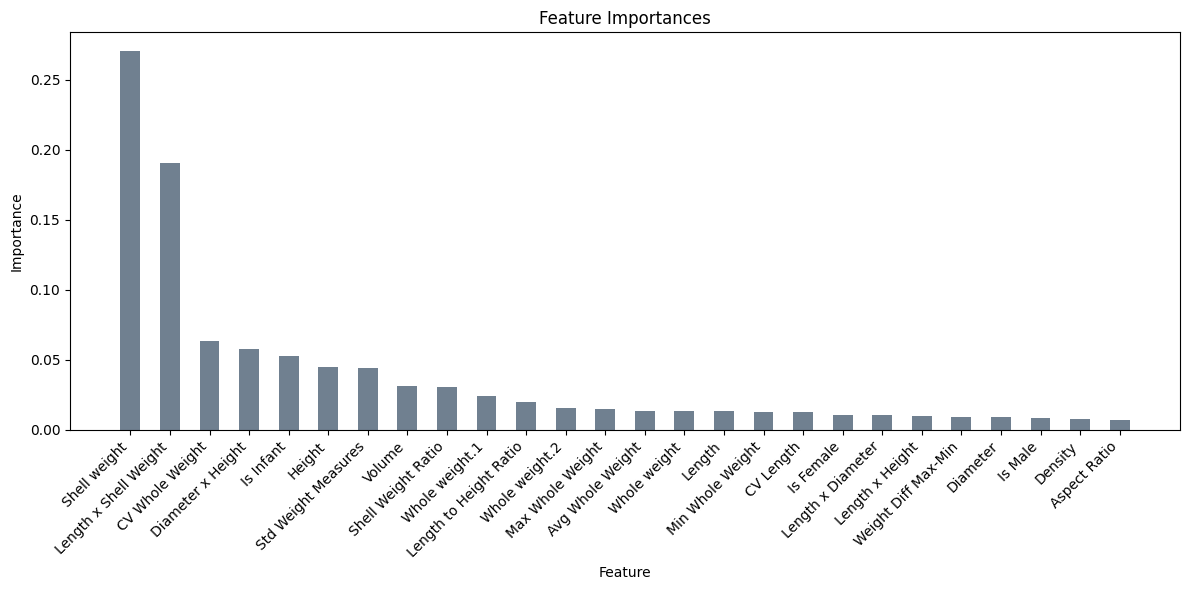

In [14]:
mean_feature_importance = np.mean(feature_importance_list, axis=0)
sorted_indices = np.argsort(mean_feature_importance)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = mean_feature_importance[sorted_indices]
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features, color = 'slategray', width=0.5)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

X_test = test_df[features]
y_test = model.predict(X_test)
y_test = np.ceil(y_test)

submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['Rings'] = y_test
submission.to_csv('submission.csv', index=False)